In [ ]:
 # Check the current python version (It should be using Python 3.11) and update pip to the latest version.
!python3 --version
!python -m pip install --user --upgrade pip

import sys
print(sys.version)


Python 3.11.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.0 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to the file in Google Drive
config_file_path = '/content/drive/My Drive/auth_config.txt'

# Read the token and shortcode
auth_config = {}
with open(config_file_path, 'r') as file:
    for line in file:
        key, value = line.strip().split('=')
        auth_config[key] = value

# Extract token and shortcode
git_token = auth_config.get('token')
short_code = auth_config.get('shortcode')

Mounted at /content/drive


In [ ]:
!git clone https://{git_token}@github.com/DeepWok/mase.git

Cloning into 'mase'...
remote: Enumerating objects: 26720, done.
remote: Counting objects: 100% (3771/3771), done.
remote: Compressing objects: 100% (555/555), done.
remote: Total 26720 (delta 3434), reused 3222 (delta 3216), pack-reused 22949 (from 2)
Receiving objects: 100% (26720/26720), 114.73 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (17099/17099), done.


In [ ]:
%%bash
# Check if the branch exists. Branch exists, so checkout to that branch otherwise create a new one.
cd mase
# if git show-ref --quiet --verify "refs/heads/lab1_${short_code}"; then
#     # Branch exists, so checkout to that branch
#     git checkout lab1_${short_code}
# else
#     # Branch doesn't exist, so create it
#     git branch lab1_{short_code} git checkout lab1_
# {short_code}
# fi

In [ ]:
%%bash
cd mase
python -m pip install -e . -vvv

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
%cd ./mase/src/

/content/mase/src


In [ ]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can load the Bert checkpoint directly from HuggingFace.

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained(checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

If you have previously ran the tutorial on Neural Architecture Search (NAS), run the following cell to import the best model obtained from the search process.

In [ ]:
# from pathlib import Path
# import dill

# with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
#     base_model = dill.load(f)

First, fetch the dataset using the `get_tokenized_dataset` utility.

In [ ]:
from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

## 1. Defining the Search Space

We'll start by defining a search space, i.e. enumerating the possible combinations of hyperparameters that Optuna can choose during search. We'll explore the following range of values for the model's hidden size, intermediate size, number of layers and number of heads.

In [ ]:
"""
Instead of applying a single precision format to all layers, mixed-precision allows different layers to use different numeric representations.
This improves the trade-off between accuracy and efficiency.
"""

import torch
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)

search_space = {
    "linear_layer_choices": [
        torch.nn.Linear, # Standard 32-bit floating point linear layer.
        LinearInteger, # Integer-based fixed-point quantization.
    ],
    "widths": [8, 16, 32],
    "frac_widths": [2, 4, 8]

}

## 2. Writing a Model Constructor

We define the following function, which will get called in each iteration of the search process. The function is passed the `trial` argument, which is an Optuna object that comes with many functionalities - see the [Trial documentation](https://optuna.readthedocs.io/en/stable/reference/trial.html) for more details. Here, we use the `trial.suggest_categorical` function, which triggers the chosen sampler to choose a layer type. The suggested integer is the index into the search space for each parameter, which we defined in the previous cell.

In [ ]:
from chop.tools.utils import deepsetattr
from copy import deepcopy
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr



def construct_model(trial):

    # Fetch the model
    # trial_model = deepcopy(model)
    config = AutoConfig.from_pretrained(checkpoint)
    trial_model = AutoModelForSequenceClassification.from_config(config)


    for param in ["widths", "frac_widths",]:
      chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)

    # Quantize layers according to optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            # If the chosen layer is integer, define the low precision config
            if new_layer_cls == LinearInteger:
                kwargs["config"] = {
                    "data_in_width": search_space["widths"][chosen_idx],
                    "data_in_frac_width": search_space["frac_widths"][chosen_idx],
                    "weight_width": search_space["widths"][chosen_idx],
                    "weight_frac_width": search_space["frac_widths"][chosen_idx],
                    "bias_width": search_space["widths"][chosen_idx],
                    "bias_frac_width": search_space["frac_widths"][chosen_idx],
                }
            # elif... (other precisions)

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data # ensures that the model structure remains the same, except for numeric precision.


            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)

    return trial_model

## 3. Defining the Objective Function

Next, we define the objective function for the search, which gets called on each trial. In each trial, we create a new model instace with chosen hyperparameters according to the defined sampler. We then use the `get_trainer` utility in Mase to run a training loop on the IMDb dataset for a number of epochs. Finally, we use `evaluate` to report back the classification accuracy on the test split.

In [ ]:
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

## 4. Launching the Search

In [ ]:
from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = TPESampler()

In [ ]:
import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=30,
    timeout=60 * 60 * 24,
)

[I 2025-02-01 14:05:21,761] A new study created in memory with name: bert-tiny-nas-study
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearInteger'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693700
1000,0.642300
1500,0.497100
2000,0.431000
2500,0.397300
3000,0.399600


[I 2025-02-01 14:07:54,181] Trial 0 finished with value: 0.8394 and parameters: {'widths': 0, 'frac_widths': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.at

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2025-02-01 14:09:48,181] Trial 1 finished with value: 0.5 and parameters: {'widths': 1, 'frac_widths': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encod

Step,Training Loss
500,0.693400
1000,0.634500
1500,0.487800
2000,0.426800
2500,0.393400
3000,0.397800


[I 2025-02-01 14:11:40,947] Trial 2 finished with value: 0.83952 and parameters: {'widths': 2, 'frac_widths': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.L

Step,Training Loss
500,0.693700
1000,0.617900
1500,0.477800
2000,0.407500
2500,0.371400
3000,0.376900


[I 2025-02-01 14:13:30,313] Trial 3 finished with value: 0.84288 and parameters: {'widths': 1, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.e

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2025-02-01 14:15:25,703] Trial 4 finished with value: 0.5 and parameters: {'widths': 0, 'frac_widths': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearIntege

Step,Training Loss
500,0.693800
1000,0.619700
1500,0.473300
2000,0.406600
2500,0.371900
3000,0.376300


[I 2025-02-01 14:17:11,440] Trial 5 finished with value: 0.8424 and parameters: {'widths': 0, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.at

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2025-02-01 14:19:04,273] Trial 6 finished with value: 0.5 and parameters: {'widths': 2, 'frac_widths': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearIntege

Step,Training Loss
500,0.693800
1000,0.643500
1500,0.492600
2000,0.433400
2500,0.400500
3000,0.394000


[I 2025-02-01 14:20:49,134] Trial 7 finished with value: 0.83616 and parameters: {'widths': 1, 'frac_widths': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100


Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2025-02-01 14:22:45,636] Trial 8 finished with value: 0.5 and parameters: {'widths': 1, 'frac_widths': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.value_type': <clas

Step,Training Loss
500,0.693800
1000,0.694100
1500,0.693700
2000,0.693800
2500,0.693200
3000,0.693400


[I 2025-02-01 14:24:37,937] Trial 9 finished with value: 0.5 and parameters: {'widths': 2, 'frac_widths': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.lin

Step,Training Loss
500,0.693800
1000,0.619400
1500,0.469200
2000,0.405900
2500,0.369000
3000,0.375600


[I 2025-02-01 14:26:23,368] Trial 10 finished with value: 0.8432 and parameters: {'widths': 1, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.e

Step,Training Loss
500,0.693800
1000,0.619400
1500,0.469200
2000,0.405900
2500,0.369000
3000,0.375600


[I 2025-02-01 14:28:13,852] Trial 11 finished with value: 0.8432 and parameters: {'widths': 1, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.e

Step,Training Loss
500,0.693800
1000,0.619400
1500,0.469200
2000,0.405900
2500,0.369000
3000,0.375600


[I 2025-02-01 14:30:02,985] Trial 12 finished with value: 0.84316 and parameters: {'widths': 1, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.

Step,Training Loss
500,0.693800
1000,0.619400
1500,0.469200
2000,0.405900
2500,0.369000
3000,0.375700


[I 2025-02-01 14:31:51,435] Trial 13 finished with value: 0.8432 and parameters: {'widths': 1, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.e

Step,Training Loss
500,0.693800
1000,0.619400
1500,0.469200
2000,0.405900
2500,0.369000
3000,0.375700


[I 2025-02-01 14:33:41,104] Trial 14 finished with value: 0.84324 and parameters: {'widths': 2, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.

Step,Training Loss
500,0.693800
1000,0.619400
1500,0.469200
2000,0.405900
2500,0.369000
3000,0.375700


[I 2025-02-01 14:35:30,095] Trial 15 finished with value: 0.84312 and parameters: {'widths': 2, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.

Step,Training Loss
500,0.693800
1000,0.646300
1500,0.466100
2000,0.411100
2500,0.380800
3000,0.378900


[I 2025-02-01 14:37:17,423] Trial 16 finished with value: 0.84084 and parameters: {'widths': 2, 'frac_widths': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.

Step,Training Loss
500,0.693800
1000,0.619400
1500,0.469200
2000,0.405900
2500,0.369000
3000,0.375600


[I 2025-02-01 14:39:03,314] Trial 17 finished with value: 0.84316 and parameters: {'widths': 2, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.

Step,Training Loss
500,0.693800
1000,0.654300
1500,0.477000
2000,0.416100
2500,0.384700
3000,0.384600


[I 2025-02-01 14:40:54,181] Trial 18 finished with value: 0.83816 and parameters: {'widths': 0, 'frac_widths': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearI

Step,Training Loss
500,0.693800
1000,0.619400
1500,0.469200
2000,0.405900
2500,0.369000
3000,0.375600


[I 2025-02-01 14:42:42,152] Trial 19 finished with value: 0.8432 and parameters: {'widths': 1, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.e

Step,Training Loss
500,0.693800
1000,0.619400
1500,0.469200
2000,0.405900
2500,0.369000
3000,0.375600


[I 2025-02-01 14:44:29,097] Trial 20 finished with value: 0.8432 and parameters: {'widths': 2, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.e

Step,Training Loss
500,0.693800
1000,0.619400
1500,0.469200
2000,0.405900
2500,0.369000
3000,0.375700


[I 2025-02-01 14:46:15,312] Trial 21 finished with value: 0.8432 and parameters: {'widths': 1, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.e

Step,Training Loss
500,0.693800
1000,0.619400
1500,0.469200
2000,0.405900
2500,0.369000
3000,0.375600


[I 2025-02-01 14:48:03,555] Trial 22 finished with value: 0.84324 and parameters: {'widths': 1, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.

Step,Training Loss
500,0.693800
1000,0.619400
1500,0.469200
2000,0.405900
2500,0.369000
3000,0.375700


[I 2025-02-01 14:49:49,583] Trial 23 finished with value: 0.84312 and parameters: {'widths': 1, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.

Step,Training Loss
500,0.693800
1000,0.646300
1500,0.466100
2000,0.411100
2500,0.380900
3000,0.378900


[I 2025-02-01 14:51:37,835] Trial 24 finished with value: 0.84088 and parameters: {'widths': 1, 'frac_widths': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.

Step,Training Loss
500,0.693800
1000,0.619400
1500,0.469200
2000,0.405900
2500,0.369000
3000,0.375700


[I 2025-02-01 14:53:26,278] Trial 25 finished with value: 0.8432 and parameters: {'widths': 0, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.e

Step,Training Loss
500,0.693800
1000,0.646300
1500,0.465900
2000,0.410100
2500,0.382600
3000,0.379200


[I 2025-02-01 14:55:14,633] Trial 26 finished with value: 0.84088 and parameters: {'widths': 2, 'frac_widths': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearI

Step,Training Loss
500,0.693900
1000,0.620500
1500,0.471600
2000,0.408800
2500,0.372600
3000,0.375800


[I 2025-02-01 14:57:12,138] Trial 27 finished with value: 0.84256 and parameters: {'widths': 1, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearI

Step,Training Loss
500,0.693800
1000,0.619400
1500,0.469200
2000,0.405900
2500,0.369000
3000,0.375600


[I 2025-02-01 14:58:58,989] Trial 28 finished with value: 0.8432 and parameters: {'widths': 1, 'frac_widths': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.e

Step,Training Loss
500,0.693600
1000,0.639100
1500,0.499100
2000,0.425000
2500,0.387200
3000,0.392800


[I 2025-02-01 15:00:53,285] Trial 29 finished with value: 0.83992 and parameters: {'widths': 0, 'frac_widths': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.

In [ ]:
values = [t.value for t in study.trials if t.value is not None]

print(values)

[0.8394, 0.5, 0.83952, 0.84288, 0.5, 0.8424, 0.5, 0.83616, 0.5, 0.5, 0.8432, 0.8432, 0.84316, 0.8432, 0.84324, 0.84312, 0.84084, 0.84316, 0.83816, 0.8432, 0.8432, 0.8432, 0.84324, 0.84312, 0.84088, 0.8432, 0.84088, 0.84256, 0.8432, 0.83992]


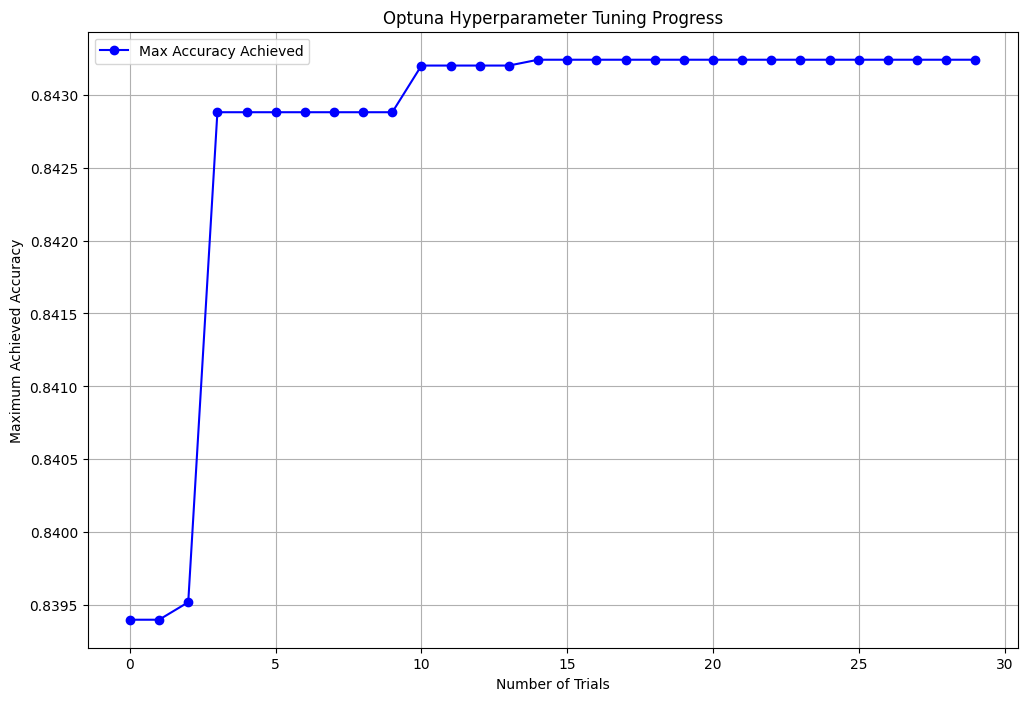

In [ ]:
import matplotlib.pyplot as plt

# Extract trial numbers and their corresponding values
trials = [t.number for t in study.trials if t.value is not None]
values = [t.value for t in study.trials if t.value is not None]

# Compute cumulative max accuracy
cumulative_max = [max(values[:i+1]) for i in range(len(values))]

# Plot
plt.figure(figsize=(12, 8))
plt.plot(trials, cumulative_max, marker='o', linestyle='-', color='b', label="Max Accuracy Achieved")

# Labels and title
plt.xlabel("Number of Trials")
plt.ylabel("Maximum Achieved Accuracy")
plt.title("Optuna Hyperparameter Tuning Progress")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

In [ ]:
from chop.tools.utils import deepsetattr
from transformers import AutoConfig, AutoModelForSequenceClassification
import torch
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)

def construct_model(trial):
    # Fetch the model
    config = AutoConfig.from_pretrained(checkpoint)
    trial_model = AutoModelForSequenceClassification.from_config(config)

    # Sample global parameters using your requested structure
    chosen_params = {}

    # Quantize layers according to Optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            # Select the layer type
            new_layer_cls_str = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )
            new_layer_cls = layer_mapping[new_layer_cls_str]

            # Skip if using standard torch.nn.Linear
            if new_layer_cls == torch.nn.Linear:
                continue

            # Define default kwargs
            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            # Assign width & frac width
            for param in ["widths", "frac_widths"]:
                chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)

            kwargs["config"] = {
                "data_in_width": search_space["widths"][chosen_idx],
                "data_in_frac_width": search_space["frac_widths"][chosen_idx],
                "weight_width": search_space["widths"][chosen_idx],
                "weight_frac_width": search_space["frac_widths"][chosen_idx],
                "bias_width": search_space["widths"][chosen_idx],
                "bias_frac_width": search_space["frac_widths"][chosen_idx],
            }

            # Add stochastic and bipolar options for all except LinearInteger
            if new_layer_cls != LinearInteger:
                for param in ["stochastic", "bipolar"]:
                    chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)

                for param in ["data_in_stochastic", "weight_stochastic", "bias_stochastic"]:
                    kwargs["config"][param] = search_space["stochastic"][chosen_idx]

                for param in ["data_in_bipolar", "weight_bipolar", "bias_bipolar"]:
                    kwargs["config"][param] = search_space["bipolar"][chosen_idx]

                if new_layer_cls in [LinearBlockLog]:
                    for param in ["data_in_exponent_bias_width", "bias_exponent_bias_width", "weight_exponent_bias_width"]:
                        chosen_idx = trial.suggest_int(param, 0, len(search_space["exponent_widths"]) - 1)
                        kwargs["config"][param] = search_space["exponent_widths"][chosen_idx]


                for param in ["data_in_exponent_width", "weight_exponent_width", "bias_exponent_width",]:
                  chosen_idx = trial.suggest_int(param, 0, len(search_space["exponent_widths"]) - 1)
                  kwargs["config"][param] = search_space["exponent_widths"][chosen_idx]

                for param in ["data_in_exponent_bias", "weight_exponent_bias", "bias_exponent_bias"]:
                    chosen_idx = trial.suggest_int(param, 0, len(search_space["exponent_bias"]) - 1)
                    kwargs["config"][param] = search_space["exponent_bias"][chosen_idx]

            # Block-based layers (FP, Log, Minifloat)
            if new_layer_cls in [LinearBlockFP, LinearBlockLog, LinearBlockMinifloat]:
                for param in ["weight_block_size", "data_in_block_size", "bias_block_size"]:
                    # Sample block sizes separately (only for block-based layers)
                    chosen_idx = trial.suggest_int(param, 0, len(search_space["block_sizes"]) - 1)
                    kwargs["config"][param] = search_space["block_sizes"][chosen_idx]

            # Binary Layers
            if new_layer_cls in [LinearBinaryScaling, LinearBinaryResidualSign]:
                  chosen_idx = trial.suggest_int("binary_training", 0, len(search_space["binary"]) - 1)
                  kwargs["config"]["binary_training"] = search_space["binary"][chosen_idx]

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data.clone()

            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)

    return trial_model



In [ ]:
import optuna
import matplotlib.pyplot as plt
from optuna.samplers import TPESampler

# Define all precision layers to test
precision_layers = [
    "LinearMinifloatDenorm", # Reduced-precision floating-point (e.g., 16-bit or lower).
    "LinearMinifloatIEEE",
    "LinearLog", # Stores values in a logarithmic scale (better range for small values). Handles small values well, Not hardware-efficient.
    "LinearBlockFP", # Groups values into blocks with a shared exponent. Good compromise Limited flexibility.
    "LinearBlockLog",
    "LinearBinary",
    "LinearBinaryScaling",
    "LinearBinaryResidualSign",
]

# Dictionary to store raw results for each precision
all_results = {}


# Loop through each precision layer and run Optuna
for precision in precision_layers:
    print()
    print(f"Running study for {precision}...")
    print()

    # Set the layer mapping for this run
    layer_mapping = {
        "torch.nn.Linear": torch.nn.Linear,
        precision: globals()[precision],  # Dynamically get the class
    }

    # Update search_space dynamically for the current precision
    search_space = {
        "linear_layer_choices": list(layer_mapping.keys()),
        "widths": [8, 16, 32],
        "frac_widths": [2, 4, 8],
        "exponent_widths": [3, 4, 5],
        "exponent_bias": [0, 1, 2],
        "exponent_bias_width": [1, 2, 3],
        "block_sizes": [[2], [4], [8]],
        "stochastic": [True, False],
        "bipolar": [True, False],
        "binary": [True, False],
    }

    # Create a new study
    sampler = TPESampler()
    study = optuna.create_study(
        direction="maximize",
        study_name=f"bert-tiny-nas-{precision}",
        sampler=sampler,
    )

    # Run the study
    study.optimize(objective, n_trials=20)

    # Store raw results for this precision
    all_results[precision] = [trial.value for trial in study.trials]
    print(all_results)

[I 2025-02-10 11:10:32,951] A new study created in memory with name: bert-tiny-nas-LinearBinary



Running study for LinearBinary...



/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693700
1000,0.694100
1500,0.693500
2000,0.694500
2500,0.694400
3000,0.694200


[I 2025-02-10 11:12:24,819] Trial 0 finished with value: 0.49068 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearBinary', 'widths': 0, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 2, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBinary', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBinary', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBinary', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBinary', 'bert.encoder.layer.1.interm

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
all_results = {'LinearMinifloatDenorm': [0.8438, 0.83252, 0.8426, 0.8408, 0.84124, 0.8414, 0.84128, 0.84388, 0.84268, 0.8192, 0.84316, 0.84212, 0.84212, 0.84472, 0.84448, 0.84472, 0.84472, 0.84472, 0.84328, 0.84472],
               'LinearMinifloatIEEE': [0.84264, 0.8422, 0.84316, 0.8182, 0.5, 0.84032, 0.84132, 0.84216, 0.84248, 0.83932, 0.84156, 0.84244, 0.84232, 0.8432, 0.84148, 0.84336, 0.84356, 0.84336, 0.84344, 0.84264],
               'LinearLog': [0.50124, 0.5, 0.49984, 0.6574, 0.50472, 0.5, 0.5, 0.5, 0.49604, 0.50052, 0.5, 0.4986, 0.50432, 0.5, 0.50244, 0.4958, 0.50392, 0.81572, 0.5, 0.5558],
               'LinearBlockFP': [0.84208, 0.84268, 0.8428, 0.84168, 0.84136, 0.84184, 0.84196, 0.84248, 0.84296, 0.84344, 0.8426, 0.84312, 0.84384, 0.84212, 0.84208, 0.84212, 0.84344, 0.8448, 0.84192, 0.84468],
               'LinearBlockLog': [0.8412, 0.84084, 0.8418, 0.84276, 0.8366, 0.84072, 0.83784, 0.84028, 0.83984, 0.843, 0.84332, 0.84344, 0.8432, 0.84352, 0.84348, 0.84384, 0.84384, 0.8438, 0.843, 0.84352]}

print(all_results)

{'LinearMinifloatDenorm': [0.8438, 0.83252, 0.8426, 0.8408, 0.84124, 0.8414, 0.84128, 0.84388, 0.84268, 0.8192, 0.84316, 0.84212, 0.84212, 0.84472, 0.84448, 0.84472, 0.84472, 0.84472, 0.84328, 0.84472], 'LinearMinifloatIEEE': [0.84264, 0.8422, 0.84316, 0.8182, 0.5, 0.84032, 0.84132, 0.84216, 0.84248, 0.83932, 0.84156, 0.84244, 0.84232, 0.8432, 0.84148, 0.84336, 0.84356, 0.84336, 0.84344, 0.84264], 'LinearLog': [0.50124, 0.5, 0.49984, 0.6574, 0.50472, 0.5, 0.5, 0.5, 0.49604, 0.50052, 0.5, 0.4986, 0.50432, 0.5, 0.50244, 0.4958, 0.50392, 0.81572, 0.5, 0.5558], 'LinearBlockFP': [0.84208, 0.84268, 0.8428, 0.84168, 0.84136, 0.84184, 0.84196, 0.84248, 0.84296, 0.84344, 0.8426, 0.84312, 0.84384, 0.84212, 0.84208, 0.84212, 0.84344, 0.8448, 0.84192, 0.84468], 'LinearBlockLog': [0.8412, 0.84084, 0.8418, 0.84276, 0.8366, 0.84072, 0.83784, 0.84028, 0.83984, 0.843, 0.84332, 0.84344, 0.8432, 0.84352, 0.84348, 0.84384, 0.84384, 0.8438, 0.843, 0.84352]}


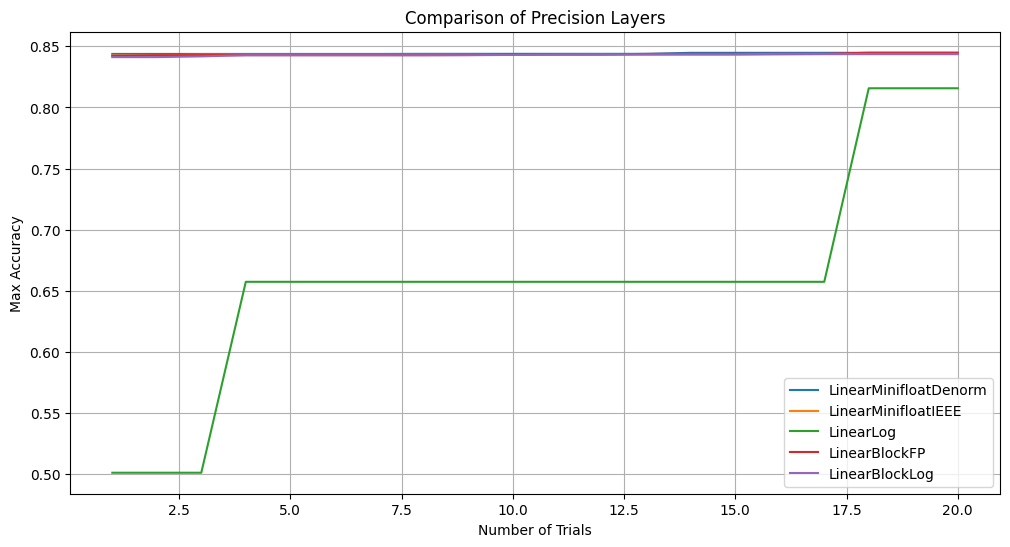

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

for precision, accuracies in all_results.items():
    max_accuracies = [max(accuracies[:i+1]) for i in range(len(accuracies))]  # Track max accuracy at each trial
    plt.plot(range(1, len(max_accuracies) + 1), max_accuracies, label=precision)

plt.xlabel("Number of Trials")
plt.ylabel("Max Accuracy")
plt.title("Comparison of Precision Layers")
plt.legend()
plt.grid()
plt.show()

# Appendx



In [ ]:
[I 2025-02-08 10:44:01,567] A new study created in memory with name: bert-tiny-nas-LinearMinifloatDenorm

Running study for LinearMinifloatDenorm...

Downloading builder script: 100%
 4.20k/4.20k [00:00<00:00, 276kB/s]
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:00, Epoch 1/1]
Step	Training Loss
500	0.693700
1000	0.622200
1500	0.457200
2000	0.405000
2500	0.375800
3000	0.381100
 [3125/3125 01:23]
[I 2025-02-08 10:47:30,402] Trial 0 finished with value: 0.8438 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatDenorm', 'widths': 2, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 1, 'bias_exponent_width': 0, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'torch.nn.Linear'}. Best is trial 0 with value: 0.8438.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:52, Epoch 1/1]
Step	Training Loss
500	0.693700
1000	0.617400
1500	0.506800
2000	0.461300
2500	0.405200
3000	0.395700
 [3125/3125 01:15]
[I 2025-02-08 10:50:41,156] Trial 1 finished with value: 0.83252 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatDenorm', 'widths': 2, 'frac_widths': 0, 'stochastic': 0, 'bipolar': 1, 'data_in_exponent_width': 0, 'weight_exponent_width': 0, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearMinifloatDenorm', 'classifier_type': 'LinearMinifloatDenorm'}. Best is trial 0 with value: 0.8438.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:45, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.620600
1500	0.469700
2000	0.406900
2500	0.370200
3000	0.376100
 [3125/3125 01:07]
[I 2025-02-08 10:53:36,145] Trial 2 finished with value: 0.8426 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearMinifloatDenorm', 'widths': 1, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 1, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 2, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatDenorm', 'bert.pooler.dense_type': 'LinearMinifloatDenorm', 'classifier_type': 'torch.nn.Linear'}. Best is trial 0 with value: 0.8438.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:40, Epoch 1/1]
Step	Training Loss
500	0.693100
1000	0.691800
1500	0.566100
2000	0.427400
2500	0.399900
3000	0.406000
 [3125/3125 01:05]
[I 2025-02-08 10:56:23,878] Trial 3 finished with value: 0.8408 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatDenorm', 'widths': 2, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 2, 'bias_exponent_width': 2, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 1, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearMinifloatDenorm', 'classifier_type': 'torch.nn.Linear'}. Best is trial 0 with value: 0.8438.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:56, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.629500
1500	0.478000
2000	0.411700
2500	0.377400
3000	0.375100
 [3125/3125 01:15]
[I 2025-02-08 10:59:38,384] Trial 4 finished with value: 0.84124 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatDenorm', 'widths': 1, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 0, 'weight_exponent_width': 1, 'bias_exponent_width': 2, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatDenorm', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'torch.nn.Linear'}. Best is trial 0 with value: 0.8438.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:26, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.622500
1500	0.471900
2000	0.409600
2500	0.372600
3000	0.378400
 [3125/3125 01:49]
[I 2025-02-08 11:03:56,277] Trial 5 finished with value: 0.8414 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatDenorm', 'widths': 0, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatDenorm', 'bert.pooler.dense_type': 'LinearMinifloatDenorm', 'classifier_type': 'torch.nn.Linear'}. Best is trial 0 with value: 0.8438.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:40, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.623500
1500	0.470200
2000	0.409500
2500	0.373300
3000	0.378000
 [3125/3125 01:56]
[I 2025-02-08 11:08:35,558] Trial 6 finished with value: 0.84128 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatDenorm', 'widths': 1, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 2, 'weight_exponent_width': 1, 'bias_exponent_width': 0, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatDenorm', 'bert.pooler.dense_type': 'LinearMinifloatDenorm', 'classifier_type': 'torch.nn.Linear'}. Best is trial 0 with value: 0.8438.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:53, Epoch 1/1]
Step	Training Loss
500	0.693900
1000	0.620600
1500	0.476000
2000	0.408600
2500	0.371100
3000	0.376700
 [3125/3125 01:17]
[I 2025-02-08 11:11:48,195] Trial 7 finished with value: 0.84388 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatDenorm', 'widths': 1, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 1, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearMinifloatDenorm', 'classifier_type': 'LinearMinifloatDenorm'}. Best is trial 7 with value: 0.84388.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:35, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.621500
1500	0.467700
2000	0.406400
2500	0.371000
3000	0.375500
 [3125/3125 00:57]
[I 2025-02-08 11:14:24,870] Trial 8 finished with value: 0.84268 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearMinifloatDenorm', 'widths': 1, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 2, 'bias_exponent_width': 0, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 0, 'bias_exponent_bias': 2, 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatDenorm', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'torch.nn.Linear'}. Best is trial 7 with value: 0.84388.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:01, Epoch 1/1]
Step	Training Loss
500	0.693300
1000	0.693200
1500	0.682300
2000	0.650700
2500	0.586100
3000	0.576500
 [3125/3125 01:25]
[I 2025-02-08 11:17:54,676] Trial 9 finished with value: 0.8192 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatDenorm', 'widths': 1, 'frac_widths': 0, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 0, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatDenorm', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatDenorm'}. Best is trial 7 with value: 0.84388.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:56, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.620400
1500	0.477800
2000	0.410100
2500	0.371000
3000	0.377000
 [3125/3125 01:22]
[I 2025-02-08 11:21:16,114] Trial 10 finished with value: 0.84316 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatDenorm', 'widths': 0, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 2, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearMinifloatDenorm', 'classifier_type': 'LinearMinifloatDenorm'}. Best is trial 7 with value: 0.84388.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:04, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.622700
1500	0.466900
2000	0.407800
2500	0.373300
3000	0.377600
 [3125/3125 01:43]
[I 2025-02-08 11:25:07,369] Trial 11 finished with value: 0.84212 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatDenorm', 'widths': 2, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatDenorm'}. Best is trial 7 with value: 0.84388.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:15, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.622700
1500	0.466900
2000	0.407800
2500	0.373300
3000	0.377600
 [3125/3125 01:30]
[I 2025-02-08 11:28:57,123] Trial 12 finished with value: 0.84212 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatDenorm', 'widths': 2, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 1, 'data_in_exponent_width': 2, 'weight_exponent_width': 2, 'bias_exponent_width': 0, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatDenorm'}. Best is trial 7 with value: 0.84388.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:48, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.619700
1500	0.472200
2000	0.405200
2500	0.370000
3000	0.375300
 [3125/3125 01:11]
[I 2025-02-08 11:31:59,670] Trial 13 finished with value: 0.84472 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatDenorm', 'widths': 0, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 1, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatDenorm'}. Best is trial 13 with value: 0.84472.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:53, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.617000
1500	0.474300
2000	0.405300
2500	0.369500
3000	0.376600
 [3125/3125 01:15]
[I 2025-02-08 11:35:11,175] Trial 14 finished with value: 0.84448 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatDenorm', 'widths': 0, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearMinifloatDenorm', 'classifier_type': 'LinearMinifloatDenorm'}. Best is trial 13 with value: 0.84472.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:52, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.619700
1500	0.472300
2000	0.405200
2500	0.370100
3000	0.375300
 [3125/3125 01:15]
[I 2025-02-08 11:38:21,214] Trial 15 finished with value: 0.84472 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatDenorm', 'widths': 0, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatDenorm'}. Best is trial 13 with value: 0.84472.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:51, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.619700
1500	0.472200
2000	0.405200
2500	0.370100
3000	0.375300
 [3125/3125 01:10]
[I 2025-02-08 11:41:24,949] Trial 16 finished with value: 0.84472 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatDenorm', 'widths': 0, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 1, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatDenorm'}. Best is trial 13 with value: 0.84472.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:49, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.619700
1500	0.472300
2000	0.405200
2500	0.370100
3000	0.375300
 [3125/3125 01:13]
[I 2025-02-08 11:44:30,111] Trial 17 finished with value: 0.84472 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatDenorm', 'widths': 0, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 0, 'bias_exponent_width': 2, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatDenorm'}. Best is trial 13 with value: 0.84472.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:43, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.620900
1500	0.466300
2000	0.405600
2500	0.369700
3000	0.375900
 [3125/3125 01:16]
[I 2025-02-08 11:47:32,582] Trial 18 finished with value: 0.84328 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatDenorm', 'widths': 0, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 1, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 1, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatDenorm'}. Best is trial 13 with value: 0.84472.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:49, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.619700
1500	0.472300
2000	0.405200
2500	0.370000
3000	0.375300
 [3125/3125 01:14]
[I 2025-02-08 11:50:39,193] Trial 19 finished with value: 0.84472 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatDenorm', 'widths': 0, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 0, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatDenorm', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatDenorm'}. Best is trial 13 with value: 0.84472.
[I 2025-02-08 11:50:39,310] A new study created in memory with name: bert-tiny-nas-LinearMinifloatIEEE
{'LinearMinifloatDenorm': [0.8438, 0.83252, 0.8426, 0.8408, 0.84124, 0.8414, 0.84128, 0.84388, 0.84268, 0.8192, 0.84316, 0.84212, 0.84212, 0.84472, 0.84448, 0.84472, 0.84472, 0.84472, 0.84328, 0.84472]}

Running study for LinearMinifloatIEEE...

/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:21, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.622100
1500	0.468800
2000	0.406100
2500	0.370700
3000	0.375600
 [3125/3125 01:40]
[I 2025-02-08 11:54:43,048] Trial 0 finished with value: 0.84264 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatIEEE', 'widths': 1, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 2, 'bias_exponent_width': 2, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'torch.nn.Linear'}. Best is trial 0 with value: 0.84264.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:22, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.621300
1500	0.468500
2000	0.407700
2500	0.371900
3000	0.377200
 [3125/3125 02:41]
[I 2025-02-08 12:00:49,624] Trial 1 finished with value: 0.8422 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatIEEE', 'widths': 2, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 0, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatIEEE', 'bert.pooler.dense_type': 'LinearMinifloatIEEE', 'classifier_type': 'torch.nn.Linear'}. Best is trial 0 with value: 0.84264.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:58, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.622000
1500	0.475800
2000	0.408600
2500	0.370200
3000	0.376200
 [3125/3125 02:18]
[I 2025-02-08 12:06:09,319] Trial 2 finished with value: 0.84316 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatIEEE', 'widths': 0, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatIEEE', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatIEEE'}. Best is trial 2 with value: 0.84316.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:45, Epoch 1/1]
Step	Training Loss
500	0.693900
1000	0.686700
1500	0.526400
2000	0.438300
2500	0.412200
3000	0.408200
 [3125/3125 01:06]
[I 2025-02-08 12:09:04,307] Trial 3 finished with value: 0.8182 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatIEEE', 'widths': 2, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 1, 'bias_exponent_width': 0, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'torch.nn.Linear'}. Best is trial 2 with value: 0.84316.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:20, Epoch 1/1]
Step	Training Loss
500	0.692900
1000	0.693300
1500	0.693300
2000	0.694000
2500	0.694900
3000	0.693900
 [3125/3125 01:42]
[I 2025-02-08 12:13:09,925] Trial 4 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatIEEE', 'widths': 1, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 0, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearMinifloatIEEE', 'classifier_type': 'LinearMinifloatIEEE'}. Best is trial 2 with value: 0.84316.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:12, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.631000
1500	0.488200
2000	0.419000
2500	0.379400
3000	0.376900
 [3125/3125 01:33]
[I 2025-02-08 12:16:57,437] Trial 5 finished with value: 0.84032 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearMinifloatIEEE', 'widths': 0, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 0, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatIEEE', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'torch.nn.Linear'}. Best is trial 2 with value: 0.84316.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:58, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.621800
1500	0.474100
2000	0.409500
2500	0.372800
3000	0.376800
 [3125/3125 02:15]
[I 2025-02-08 12:22:13,988] Trial 6 finished with value: 0.84132 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatIEEE', 'widths': 0, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 2, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatIEEE', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'torch.nn.Linear'}. Best is trial 2 with value: 0.84316.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:33, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.620900
1500	0.471000
2000	0.407500
2500	0.371800
3000	0.375800
 [3125/3125 02:50]
[I 2025-02-08 12:28:40,177] Trial 7 finished with value: 0.84216 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatIEEE', 'widths': 1, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 2, 'bias_exponent_width': 1, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatIEEE', 'bert.pooler.dense_type': 'LinearMinifloatIEEE', 'classifier_type': 'LinearMinifloatIEEE'}. Best is trial 2 with value: 0.84316.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:16, Epoch 1/1]
Step	Training Loss
500	0.693900
1000	0.620800
1500	0.469900
2000	0.407000
2500	0.370900
3000	0.376000
 [3125/3125 01:38]
[I 2025-02-08 12:32:37,849] Trial 8 finished with value: 0.84248 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatIEEE', 'widths': 2, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 1, 'bias_exponent_width': 1, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatIEEE', 'bert.pooler.dense_type': 'LinearMinifloatIEEE', 'classifier_type': 'torch.nn.Linear'}. Best is trial 2 with value: 0.84316.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:58, Epoch 1/1]
Step	Training Loss
500	0.693900
1000	0.627900
1500	0.501600
2000	0.428800
2500	0.382200
3000	0.379600
 [3125/3125 01:16]
[I 2025-02-08 12:35:55,610] Trial 9 finished with value: 0.83932 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatIEEE', 'widths': 0, 'frac_widths': 0, 'stochastic': 0, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearMinifloatIEEE', 'classifier_type': 'torch.nn.Linear'}. Best is trial 2 with value: 0.84316.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:06, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.624200
1500	0.468200
2000	0.409300
2500	0.373200
3000	0.377800
 [3125/3125 02:26]
[I 2025-02-08 12:41:30,247] Trial 10 finished with value: 0.84156 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatIEEE', 'widths': 0, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 1, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatIEEE', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatIEEE'}. Best is trial 2 with value: 0.84316.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:27, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.623400
1500	0.466300
2000	0.407500
2500	0.371700
3000	0.377200
 [3125/3125 01:50]
[I 2025-02-08 12:45:50,732] Trial 11 finished with value: 0.84244 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatIEEE', 'widths': 1, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 2, 'bias_exponent_width': 2, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatIEEE'}. Best is trial 2 with value: 0.84316.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:39, Epoch 1/1]
Step	Training Loss
500	0.694000
1000	0.623600
1500	0.463100
2000	0.408200
2500	0.373500
3000	0.377200
 [3125/3125 02:00]
[I 2025-02-08 12:50:33,938] Trial 12 finished with value: 0.84232 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatIEEE', 'widths': 1, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 0, 'weight_exponent_width': 2, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatIEEE'}. Best is trial 2 with value: 0.84316.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:47, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.623300
1500	0.475700
2000	0.407200
2500	0.370300
3000	0.375800
 [3125/3125 02:09]
[I 2025-02-08 12:55:33,039] Trial 13 finished with value: 0.8432 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatIEEE', 'widths': 0, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 2, 'bias_exponent_width': 2, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatIEEE'}. Best is trial 13 with value: 0.8432.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:04, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.623700
1500	0.469100
2000	0.408400
2500	0.372500
3000	0.377700
 [3125/3125 02:17]
[I 2025-02-08 13:00:56,892] Trial 14 finished with value: 0.84148 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatIEEE', 'widths': 0, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 1, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 0, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatIEEE'}. Best is trial 13 with value: 0.8432.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:50, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.622800
1500	0.468400
2000	0.406800
2500	0.370300
3000	0.376700
 [3125/3125 02:11]
[I 2025-02-08 13:06:01,174] Trial 15 finished with value: 0.84336 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatIEEE', 'widths': 0, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 2, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatIEEE', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatIEEE'}. Best is trial 15 with value: 0.84336.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:48, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.622000
1500	0.474400
2000	0.406400
2500	0.369200
3000	0.376600
 [3125/3125 02:07]
[I 2025-02-08 13:11:00,080] Trial 16 finished with value: 0.84356 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatIEEE', 'widths': 0, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 2, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatIEEE'}. Best is trial 16 with value: 0.84356.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:52, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.622800
1500	0.468400
2000	0.406800
2500	0.370300
3000	0.376700
 [3125/3125 02:10]
[I 2025-02-08 13:16:05,191] Trial 17 finished with value: 0.84336 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatIEEE', 'widths': 0, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 2, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatIEEE', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatIEEE'}. Best is trial 16 with value: 0.84356.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:59, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.618400
1500	0.474300
2000	0.405300
2500	0.369500
3000	0.375900
 [3125/3125 02:20]
[I 2025-02-08 13:21:27,860] Trial 18 finished with value: 0.84344 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatIEEE', 'widths': 1, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 2, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearMinifloatIEEE', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatIEEE'}. Best is trial 16 with value: 0.84356.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:41, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.619400
1500	0.465800
2000	0.404500
2500	0.369400
3000	0.374000
 [3125/3125 02:02]
[I 2025-02-08 13:26:13,436] Trial 19 finished with value: 0.84264 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearMinifloatIEEE', 'widths': 1, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 2, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.key_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearMinifloatIEEE', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearMinifloatIEEE'}. Best is trial 16 with value: 0.84356.
[I 2025-02-08 13:26:13,560] A new study created in memory with name: bert-tiny-nas-LinearLog
{'LinearMinifloatDenorm': [0.8438, 0.83252, 0.8426, 0.8408, 0.84124, 0.8414, 0.84128, 0.84388, 0.84268, 0.8192, 0.84316, 0.84212, 0.84212, 0.84472, 0.84448, 0.84472, 0.84472, 0.84472, 0.84328, 0.84472], 'LinearMinifloatIEEE': [0.84264, 0.8422, 0.84316, 0.8182, 0.5, 0.84032, 0.84132, 0.84216, 0.84248, 0.83932, 0.84156, 0.84244, 0.84232, 0.8432, 0.84148, 0.84336, 0.84356, 0.84336, 0.84344, 0.84264]}

Running study for LinearLog...

/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:31, Epoch 1/1]
Step	Training Loss
500	0.791400
1000	0.744100
1500	0.734000
2000	0.731800
2500	0.728300
3000	0.726900
 [3125/3125 00:51]
[I 2025-02-08 13:28:39,405] Trial 0 finished with value: 0.50124 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearLog', 'widths': 0, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 2, 'bias_exponent_width': 1, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_type': 'LinearLog', 'bert.encoder.layer.0.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.query_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.key_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearLog'}. Best is trial 0 with value: 0.50124.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:18, Epoch 1/1]
Step	Training Loss
500	0.693900
1000	0.693600
1500	0.694000
2000	0.694400
2500	0.693900
3000	0.694700
 [3125/3125 00:40]
[I 2025-02-08 13:30:40,778] Trial 1 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearLog', 'widths': 1, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 0, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.1.output.dense_type': 'LinearLog', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'torch.nn.Linear'}. Best is trial 0 with value: 0.50124.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:20, Epoch 1/1]
Step	Training Loss
500	0.696600
1000	0.696900
1500	0.695000
2000	0.698000
2500	0.694700
3000	0.694700
 [3125/3125 00:40]
[I 2025-02-08 13:32:43,586] Trial 2 finished with value: 0.49984 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearLog', 'widths': 0, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 1, 'data_in_exponent_width': 2, 'weight_exponent_width': 1, 'bias_exponent_width': 0, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_type': 'LinearLog', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.key_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 0 with value: 0.50124.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:21, Epoch 1/1]
Step	Training Loss
500	1.104400
1000	0.961700
1500	0.888300
2000	0.795900
2500	0.717600
3000	0.678200
 [3125/3125 00:44]
[I 2025-02-08 13:34:51,915] Trial 3 finished with value: 0.6574 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearLog', 'widths': 0, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.1.output.dense_type': 'LinearLog', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearLog'}. Best is trial 3 with value: 0.6574.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:23, Epoch 1/1]
Step	Training Loss
500	0.698800
1000	0.695700
1500	0.697500
2000	0.699000
2500	0.695300
3000	0.697200
 [3125/3125 00:44]
[I 2025-02-08 13:37:02,903] Trial 4 finished with value: 0.50472 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearLog', 'widths': 0, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_type': 'LinearLog', 'bert.encoder.layer.0.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.1.output.dense_type': 'LinearLog', 'bert.pooler.dense_type': 'LinearLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 3 with value: 0.6574.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:21, Epoch 1/1]
Step	Training Loss
500	0.694200
1000	0.693300
1500	0.694000
2000	0.694300
2500	0.693900
3000	0.694600
 [3125/3125 00:40]
[I 2025-02-08 13:39:07,621] Trial 5 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearLog', 'widths': 2, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 2, 'bias_exponent_width': 2, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 0, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearLog', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'torch.nn.Linear'}. Best is trial 3 with value: 0.6574.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:15, Epoch 1/1]
Step	Training Loss
500	0.718100
1000	0.721500
1500	0.721500
2000	0.704500
2500	0.693100
3000	0.693100
 [3125/3125 00:37]
[I 2025-02-08 13:41:02,914] Trial 6 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearLog', 'widths': 2, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearLog', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearLog'}. Best is trial 3 with value: 0.6574.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:22, Epoch 1/1]
Step	Training Loss
500	0.694200
1000	0.693300
1500	0.694000
2000	0.694300
2500	0.693900
3000	0.694600
 [3125/3125 00:43]
[I 2025-02-08 13:43:11,302] Trial 7 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearLog', 'widths': 0, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 2, 'bias_exponent_width': 1, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.key_type': 'LinearLog', 'bert.encoder.layer.0.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearLog', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'torch.nn.Linear'}. Best is trial 3 with value: 0.6574.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:30, Epoch 1/1]
Step	Training Loss
500	0.695600
1000	0.695200
1500	0.692900
2000	0.696200
2500	0.694900
3000	0.694700
 [3125/3125 00:51]
[I 2025-02-08 13:45:35,040] Trial 8 finished with value: 0.49604 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearLog', 'widths': 0, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_type': 'LinearLog', 'bert.encoder.layer.0.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.1.output.dense_type': 'LinearLog', 'bert.pooler.dense_type': 'LinearLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 3 with value: 0.6574.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:19, Epoch 1/1]
Step	Training Loss
500	0.694500
1000	0.693800
1500	0.693600
2000	0.693700
2500	0.693700
3000	0.694100
 [3125/3125 00:42]
[I 2025-02-08 13:47:39,910] Trial 9 finished with value: 0.50052 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearLog', 'widths': 0, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 2, 'bias_exponent_width': 0, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 0, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.query_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'torch.nn.Linear'}. Best is trial 3 with value: 0.6574.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:20, Epoch 1/1]
Step	Training Loss
500	0.778400
1000	0.706300
1500	0.710500
2000	0.701100
2500	0.693100
3000	0.693100
 [3125/3125 00:40]
[I 2025-02-08 13:49:42,952] Trial 10 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearLog', 'widths': 1, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 1, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearLog', 'classifier_type': 'LinearLog'}. Best is trial 3 with value: 0.6574.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:25, Epoch 1/1]
Step	Training Loss
500	0.708100
1000	0.703600
1500	0.701300
2000	0.698600
2500	0.699000
3000	0.695200
 [3125/3125 00:45]
[I 2025-02-08 13:51:56,644] Trial 11 finished with value: 0.4986 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearLog', 'widths': 1, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 2, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 2, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.1.output.dense_type': 'LinearLog', 'bert.pooler.dense_type': 'LinearLog', 'classifier_type': 'LinearLog'}. Best is trial 3 with value: 0.6574.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:26, Epoch 1/1]
Step	Training Loss
500	0.903400
1000	0.864200
1500	0.840400
2000	0.823600
2500	0.822900
3000	0.832500
 [3125/3125 00:49]
[I 2025-02-08 13:54:15,406] Trial 12 finished with value: 0.50432 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearLog', 'widths': 0, 'frac_widths': 0, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 1, 'bias_exponent_width': 2, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 2, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.self.key_type': 'LinearLog', 'bert.encoder.layer.0.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.1.output.dense_type': 'LinearLog', 'bert.pooler.dense_type': 'LinearLog', 'classifier_type': 'LinearLog'}. Best is trial 3 with value: 0.6574.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:22, Epoch 1/1]
Step	Training Loss
500	0.740600
1000	0.706300
1500	0.697800
2000	0.700400
2500	0.701700
3000	0.701200
 [3125/3125 00:42]
[I 2025-02-08 13:56:22,404] Trial 13 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearLog', 'widths': 1, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.1.output.dense_type': 'LinearLog', 'bert.pooler.dense_type': 'LinearLog', 'classifier_type': 'LinearLog'}. Best is trial 3 with value: 0.6574.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:27, Epoch 1/1]
Step	Training Loss
500	0.694200
1000	0.693300
1500	0.694000
2000	0.694300
2500	0.693600
3000	0.694700
 [3125/3125 00:47]
[I 2025-02-08 13:58:39,363] Trial 14 finished with value: 0.50244 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearLog', 'widths': 0, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_type': 'LinearLog', 'bert.encoder.layer.0.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.1.output.dense_type': 'LinearLog', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'torch.nn.Linear'}. Best is trial 3 with value: 0.6574.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:23, Epoch 1/1]
Step	Training Loss
500	0.693600
1000	0.694300
1500	0.693600
2000	0.696500
2500	0.695800
3000	0.693600
 [3125/3125 00:42]
[I 2025-02-08 14:00:47,463] Trial 15 finished with value: 0.4958 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearLog', 'widths': 1, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 1, 'bias_exponent_width': 2, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 2, 'bias_exponent_bias': 1, 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.1.output.dense_type': 'LinearLog', 'bert.pooler.dense_type': 'LinearLog', 'classifier_type': 'LinearLog'}. Best is trial 3 with value: 0.6574.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:24, Epoch 1/1]
Step	Training Loss
500	0.694500
1000	0.696400
1500	0.696400
2000	0.697400
2500	0.693900
3000	0.696600
 [3125/3125 00:44]
[I 2025-02-08 14:03:01,250] Trial 16 finished with value: 0.50392 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearLog', 'widths': 0, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 1, 'bias_exponent_bias': 2, 'bert.encoder.layer.0.attention.self.key_type': 'LinearLog', 'bert.encoder.layer.0.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.1.output.dense_type': 'LinearLog', 'bert.pooler.dense_type': 'LinearLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 3 with value: 0.6574.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:22, Epoch 1/1]
Step	Training Loss
500	0.837900
1000	0.783300
1500	0.684200
2000	0.552800
2500	0.473400
3000	0.452000
 [3125/3125 00:42]
[I 2025-02-08 14:05:08,057] Trial 17 finished with value: 0.81572 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearLog', 'widths': 2, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 0, 'weight_exponent_width': 1, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 2, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.1.output.dense_type': 'LinearLog', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearLog'}. Best is trial 17 with value: 0.81572.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:17, Epoch 1/1]
Step	Training Loss
500	0.724000
1000	0.697500
1500	0.695600
2000	0.693100
2500	0.693100
3000	0.693100
 [3125/3125 00:38]
[I 2025-02-08 14:07:06,856] Trial 18 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearLog', 'widths': 2, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 0, 'weight_exponent_width': 1, 'bias_exponent_width': 1, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 1, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearLog'}. Best is trial 17 with value: 0.81572.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:23, Epoch 1/1]
Step	Training Loss
500	1.107100
1000	0.956500
1500	0.908700
2000	0.832500
2500	0.771200
3000	0.731400
 [3125/3125 00:42]
[I 2025-02-08 14:09:15,417] Trial 19 finished with value: 0.5558 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearLog', 'widths': 2, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 0, 'weight_exponent_width': 1, 'bias_exponent_width': 2, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 2, 'bias_exponent_bias': 0, 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearLog', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearLog', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearLog', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearLog', 'bert.encoder.layer.1.output.dense_type': 'LinearLog', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearLog'}. Best is trial 17 with value: 0.81572.
[I 2025-02-08 14:09:15,536] A new study created in memory with name: bert-tiny-nas-LinearBlockFP
{'LinearMinifloatDenorm': [0.8438, 0.83252, 0.8426, 0.8408, 0.84124, 0.8414, 0.84128, 0.84388, 0.84268, 0.8192, 0.84316, 0.84212, 0.84212, 0.84472, 0.84448, 0.84472, 0.84472, 0.84472, 0.84328, 0.84472], 'LinearMinifloatIEEE': [0.84264, 0.8422, 0.84316, 0.8182, 0.5, 0.84032, 0.84132, 0.84216, 0.84248, 0.83932, 0.84156, 0.84244, 0.84232, 0.8432, 0.84148, 0.84336, 0.84356, 0.84336, 0.84344, 0.84264], 'LinearLog': [0.50124, 0.5, 0.49984, 0.6574, 0.50472, 0.5, 0.5, 0.5, 0.49604, 0.50052, 0.5, 0.4986, 0.50432, 0.5, 0.50244, 0.4958, 0.50392, 0.81572, 0.5, 0.5558]}

Running study for LinearBlockFP...

/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 04:50, Epoch 1/1]
Step	Training Loss
500	0.693700
1000	0.622700
1500	0.469300
2000	0.408500
2500	0.372400
3000	0.377500
 [3125/3125 04:08]
[I 2025-02-08 14:18:17,164] Trial 0 finished with value: 0.84208 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockFP', 'widths': 1, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 2, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 0, 'weight_block_size': 0, 'data_in_block_size': 2, 'bias_block_size': 0, 'bert.encoder.layer.0.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.output.dense_type': 'LinearBlockFP', 'bert.pooler.dense_type': 'LinearBlockFP', 'classifier_type': 'LinearBlockFP'}. Best is trial 0 with value: 0.84208.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:24, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.622900
1500	0.468400
2000	0.407600
2500	0.371000
3000	0.376000
 [3125/3125 01:46]
[I 2025-02-08 14:22:30,669] Trial 1 finished with value: 0.84268 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearBlockFP', 'widths': 0, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 0, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 1, 'bias_exponent_bias': 2, 'weight_block_size': 0, 'data_in_block_size': 1, 'bias_block_size': 1, 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearBlockFP', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'torch.nn.Linear'}. Best is trial 1 with value: 0.84268.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:43, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.621200
1500	0.466500
2000	0.406200
2500	0.371300
3000	0.374600
 [3125/3125 03:00]
[I 2025-02-08 14:29:17,581] Trial 2 finished with value: 0.8428 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockFP', 'widths': 1, 'frac_widths': 0, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 1, 'bias_exponent_width': 1, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'weight_block_size': 0, 'data_in_block_size': 0, 'bias_block_size': 2, 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.0.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.output.dense_type': 'LinearBlockFP', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearBlockFP'}. Best is trial 2 with value: 0.8428.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:58, Epoch 1/1]
Step	Training Loss
500	0.693900
1000	0.622700
1500	0.466400
2000	0.407700
2500	0.372400
3000	0.376400
 [3125/3125 01:19]
[I 2025-02-08 14:32:38,156] Trial 3 finished with value: 0.84168 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockFP', 'widths': 0, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 1, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 0, 'bias_exponent_bias': 0, 'weight_block_size': 0, 'data_in_block_size': 1, 'bias_block_size': 0, 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearBlockFP', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearBlockFP'}. Best is trial 2 with value: 0.8428.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:16, Epoch 1/1]
Step	Training Loss
500	0.693900
1000	0.619500
1500	0.468000
2000	0.407800
2500	0.373300
3000	0.375100
 [3125/3125 02:38]
[I 2025-02-08 14:38:35,753] Trial 4 finished with value: 0.84136 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearBlockFP', 'widths': 2, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 1, 'bias_exponent_width': 1, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 2, 'bias_exponent_bias': 1, 'weight_block_size': 0, 'data_in_block_size': 2, 'bias_block_size': 0, 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearBlockFP'}. Best is trial 2 with value: 0.8428.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:31, Epoch 1/1]
Step	Training Loss
500	0.693900
1000	0.625300
1500	0.463500
2000	0.407500
2500	0.375900
3000	0.376500
 [3125/3125 01:52]
[I 2025-02-08 14:43:02,613] Trial 5 finished with value: 0.84184 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockFP', 'widths': 2, 'frac_widths': 0, 'stochastic': 0, 'bipolar': 1, 'data_in_exponent_width': 2, 'weight_exponent_width': 1, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 2, 'bias_exponent_bias': 1, 'weight_block_size': 2, 'data_in_block_size': 1, 'bias_block_size': 0, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearBlockFP'}. Best is trial 2 with value: 0.8428.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:14, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.620100
1500	0.472500
2000	0.406800
2500	0.370400
3000	0.375200
 [3125/3125 02:37]
[I 2025-02-08 14:48:56,656] Trial 6 finished with value: 0.84196 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockFP', 'widths': 2, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 0, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'weight_block_size': 1, 'data_in_block_size': 0, 'bias_block_size': 1, 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.0.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockFP', 'classifier_type': 'torch.nn.Linear'}. Best is trial 2 with value: 0.8428.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:04, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.622300
1500	0.470000
2000	0.408100
2500	0.371300
3000	0.375000
 [3125/3125 02:24]
[I 2025-02-08 14:54:28,846] Trial 7 finished with value: 0.84248 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearBlockFP', 'widths': 2, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 1, 'bias_exponent_width': 0, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 0, 'weight_block_size': 1, 'data_in_block_size': 2, 'bias_block_size': 2, 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.output.dense_type': 'LinearBlockFP', 'bert.pooler.dense_type': 'LinearBlockFP', 'classifier_type': 'torch.nn.Linear'}. Best is trial 2 with value: 0.8428.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:39, Epoch 1/1]
Step	Training Loss
500	0.693700
1000	0.621200
1500	0.467500
2000	0.405200
2500	0.370300
3000	0.374500
 [3125/3125 03:03]
[I 2025-02-08 15:01:13,899] Trial 8 finished with value: 0.84296 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockFP', 'widths': 2, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 2, 'bias_exponent_width': 2, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 0, 'bias_exponent_bias': 0, 'weight_block_size': 2, 'data_in_block_size': 0, 'bias_block_size': 1, 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.0.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockFP', 'classifier_type': 'torch.nn.Linear'}. Best is trial 8 with value: 0.84296.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:42, Epoch 1/1]
Step	Training Loss
500	0.693900
1000	0.620400
1500	0.470300
2000	0.407200
2500	0.370900
3000	0.376100
 [3125/3125 02:02]
[I 2025-02-08 15:06:00,502] Trial 9 finished with value: 0.84344 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockFP', 'widths': 1, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 1, 'bias_exponent_width': 0, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'weight_block_size': 1, 'data_in_block_size': 2, 'bias_block_size': 2, 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearBlockFP', 'bert.pooler.dense_type': 'LinearBlockFP', 'classifier_type': 'torch.nn.Linear'}. Best is trial 9 with value: 0.84344.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:58, Epoch 1/1]
Step	Training Loss
500	0.693900
1000	0.622700
1500	0.469000
2000	0.407800
2500	0.370800
3000	0.376700
 [3125/3125 02:20]
[I 2025-02-08 15:11:21,860] Trial 10 finished with value: 0.8426 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockFP', 'widths': 1, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 0, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'weight_block_size': 1, 'data_in_block_size': 2, 'bias_block_size': 2, 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearBlockFP', 'bert.pooler.dense_type': 'LinearBlockFP', 'classifier_type': 'torch.nn.Linear'}. Best is trial 9 with value: 0.84344.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:59, Epoch 1/1]
Step	Training Loss
500	0.693900
1000	0.620700
1500	0.470100
2000	0.406200
2500	0.369600
3000	0.376500
 [3125/3125 02:21]
[I 2025-02-08 15:16:45,918] Trial 11 finished with value: 0.84312 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockFP', 'widths': 1, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 2, 'bias_exponent_width': 0, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 0, 'bias_exponent_bias': 1, 'weight_block_size': 2, 'data_in_block_size': 0, 'bias_block_size': 1, 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockFP', 'classifier_type': 'torch.nn.Linear'}. Best is trial 9 with value: 0.84344.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:00, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.620900
1500	0.470700
2000	0.406500
2500	0.369000
3000	0.376500
 [3125/3125 02:22]
[I 2025-02-08 15:22:10,663] Trial 12 finished with value: 0.84384 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockFP', 'widths': 1, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 0, 'weight_exponent_width': 2, 'bias_exponent_width': 0, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 0, 'bias_exponent_bias': 2, 'weight_block_size': 2, 'data_in_block_size': 0, 'bias_block_size': 2, 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockFP', 'classifier_type': 'torch.nn.Linear'}. Best is trial 12 with value: 0.84384.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:44, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.622000
1500	0.473600
2000	0.408600
2500	0.370800
3000	0.377200
 [3125/3125 02:07]
[I 2025-02-08 15:27:05,067] Trial 13 finished with value: 0.84212 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockFP', 'widths': 0, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 0, 'weight_exponent_width': 2, 'bias_exponent_width': 0, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 1, 'bias_exponent_bias': 2, 'weight_block_size': 2, 'data_in_block_size': 1, 'bias_block_size': 2, 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockFP', 'classifier_type': 'torch.nn.Linear'}. Best is trial 12 with value: 0.84384.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:23, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.622900
1500	0.470300
2000	0.408400
2500	0.371100
3000	0.377000
 [3125/3125 02:45]
[I 2025-02-08 15:33:16,123] Trial 14 finished with value: 0.84208 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockFP', 'widths': 1, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 2, 'bias_exponent_width': 0, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 1, 'bias_exponent_bias': 2, 'weight_block_size': 1, 'data_in_block_size': 1, 'bias_block_size': 2, 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearBlockFP', 'bert.pooler.dense_type': 'LinearBlockFP', 'classifier_type': 'torch.nn.Linear'}. Best is trial 12 with value: 0.84384.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:53, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.622000
1500	0.473600
2000	0.408600
2500	0.370800
3000	0.377200
 [3125/3125 02:14]
[I 2025-02-08 15:38:26,405] Trial 15 finished with value: 0.84212 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockFP', 'widths': 1, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 0, 'weight_exponent_width': 1, 'bias_exponent_width': 0, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 2, 'weight_block_size': 1, 'data_in_block_size': 2, 'bias_block_size': 2, 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockFP', 'classifier_type': 'torch.nn.Linear'}. Best is trial 12 with value: 0.84384.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:30, Epoch 1/1]
Step	Training Loss
500	0.693900
1000	0.620400
1500	0.470300
2000	0.407200
2500	0.370900
3000	0.376100
 [3125/3125 01:53]
[I 2025-02-08 15:42:53,429] Trial 16 finished with value: 0.84344 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockFP', 'widths': 0, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 2, 'bias_exponent_width': 0, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'weight_block_size': 2, 'data_in_block_size': 0, 'bias_block_size': 2, 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearBlockFP', 'bert.pooler.dense_type': 'LinearBlockFP', 'classifier_type': 'torch.nn.Linear'}. Best is trial 12 with value: 0.84384.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:00, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.620000
1500	0.470800
2000	0.405700
2500	0.368100
3000	0.376700
 [3125/3125 02:24]
[I 2025-02-08 15:48:21,322] Trial 17 finished with value: 0.8448 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockFP', 'widths': 1, 'frac_widths': 0, 'stochastic': 0, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'weight_block_size': 1, 'data_in_block_size': 1, 'bias_block_size': 1, 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockFP', 'classifier_type': 'torch.nn.Linear'}. Best is trial 17 with value: 0.8448.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:18, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.621500
1500	0.476900
2000	0.408400
2500	0.369800
3000	0.376300
 [2466/3125 02:06 < 00:33, 19.44 it/s]
 [3125/3125 02:41]
[I 2025-02-08 15:54:23,526] Trial 18 finished with value: 0.84192 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockFP', 'widths': 1, 'frac_widths': 0, 'stochastic': 0, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 0, 'bias_exponent_bias': 1, 'weight_block_size': 1, 'data_in_block_size': 1, 'bias_block_size': 1, 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockFP', 'classifier_type': 'torch.nn.Linear'}. Best is trial 17 with value: 0.8448.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:59, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.619900
1500	0.470700
2000	0.405800
2500	0.368100
3000	0.376600
 [3125/3125 02:20]
[I 2025-02-08 15:59:46,367] Trial 19 finished with value: 0.84468 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockFP', 'widths': 0, 'frac_widths': 0, 'stochastic': 0, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'weight_block_size': 2, 'data_in_block_size': 0, 'bias_block_size': 1, 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockFP', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockFP', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockFP', 'classifier_type': 'torch.nn.Linear'}. Best is trial 17 with value: 0.8448.
[I 2025-02-08 15:59:46,521] A new study created in memory with name: bert-tiny-nas-LinearBlockLog
{'LinearMinifloatDenorm': [0.8438, 0.83252, 0.8426, 0.8408, 0.84124, 0.8414, 0.84128, 0.84388, 0.84268, 0.8192, 0.84316, 0.84212, 0.84212, 0.84472, 0.84448, 0.84472, 0.84472, 0.84472, 0.84328, 0.84472], 'LinearMinifloatIEEE': [0.84264, 0.8422, 0.84316, 0.8182, 0.5, 0.84032, 0.84132, 0.84216, 0.84248, 0.83932, 0.84156, 0.84244, 0.84232, 0.8432, 0.84148, 0.84336, 0.84356, 0.84336, 0.84344, 0.84264], 'LinearLog': [0.50124, 0.5, 0.49984, 0.6574, 0.50472, 0.5, 0.5, 0.5, 0.49604, 0.50052, 0.5, 0.4986, 0.50432, 0.5, 0.50244, 0.4958, 0.50392, 0.81572, 0.5, 0.5558], 'LinearBlockFP': [0.84208, 0.84268, 0.8428, 0.84168, 0.84136, 0.84184, 0.84196, 0.84248, 0.84296, 0.84344, 0.8426, 0.84312, 0.84384, 0.84212, 0.84208, 0.84212, 0.84344, 0.8448, 0.84192, 0.84468]}

Running study for LinearBlockLog...

/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:54, Epoch 1/1]
Step	Training Loss
500	0.694200
1000	0.624500
1500	0.473400
2000	0.408800
2500	0.374200
3000	0.377600
 [3125/3125 02:16]
[I 2025-02-08 16:04:59,550] Trial 0 finished with value: 0.8412 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockLog', 'widths': 1, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_bias_width': 0, 'bias_exponent_bias_width': 2, 'weight_exponent_bias_width': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 2, 'bias_exponent_width': 0, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 0, 'bias_exponent_bias': 2, 'weight_block_size': 2, 'data_in_block_size': 0, 'bias_block_size': 2, 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearBlockLog'}. Best is trial 0 with value: 0.8412.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:55, Epoch 1/1]
Step	Training Loss
500	0.694100
1000	0.627900
1500	0.488600
2000	0.412400
2500	0.371200
3000	0.378800
 [3125/3125 03:16]
[I 2025-02-08 16:12:13,874] Trial 1 finished with value: 0.84084 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockLog', 'widths': 2, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 1, 'data_in_exponent_bias_width': 2, 'bias_exponent_bias_width': 1, 'weight_exponent_bias_width': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 2, 'bias_exponent_width': 2, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 0, 'bias_exponent_bias': 0, 'weight_block_size': 2, 'data_in_block_size': 0, 'bias_block_size': 2, 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.0.attention.self.value_type': 'LinearBlockLog', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearBlockLog', 'bert.encoder.layer.0.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearBlockLog'}. Best is trial 0 with value: 0.8412.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:01, Epoch 1/1]
Step	Training Loss
500	0.694000
1000	0.622900
1500	0.478500
2000	0.409700
2500	0.372200
3000	0.375900
 [3125/3125 01:28]
[I 2025-02-08 16:15:45,550] Trial 2 finished with value: 0.8418 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearBlockLog', 'widths': 2, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_bias_width': 2, 'bias_exponent_bias_width': 1, 'weight_exponent_bias_width': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 1, 'weight_block_size': 0, 'data_in_block_size': 0, 'bias_block_size': 2, 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearBlockLog', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearBlockLog'}. Best is trial 2 with value: 0.8418.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:27, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.615400
1500	0.472900
2000	0.410200
2500	0.371100
3000	0.377600
 [3125/3125 02:49]
[I 2025-02-08 16:22:05,032] Trial 3 finished with value: 0.84276 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockLog', 'widths': 2, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_bias_width': 1, 'bias_exponent_bias_width': 2, 'weight_exponent_bias_width': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 2, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 0, 'bias_exponent_bias': 0, 'weight_block_size': 0, 'data_in_block_size': 0, 'bias_block_size': 0, 'bert.encoder.layer.0.attention.self.value_type': 'LinearBlockLog', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearBlockLog', 'bert.encoder.layer.0.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.output.dense_type': 'LinearBlockLog', 'bert.pooler.dense_type': 'LinearBlockLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 3 with value: 0.84276.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 04:30, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.619400
1500	0.477300
2000	0.413300
2500	0.375600
3000	0.380000
 [3125/3125 03:52]
[I 2025-02-08 16:30:29,884] Trial 4 finished with value: 0.8366 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockLog', 'widths': 1, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_bias_width': 0, 'bias_exponent_bias_width': 2, 'weight_exponent_bias_width': 2, 'data_in_exponent_width': 0, 'weight_exponent_width': 2, 'bias_exponent_width': 1, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'weight_block_size': 0, 'data_in_block_size': 2, 'bias_block_size': 2, 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearBlockLog', 'bert.encoder.layer.0.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.output.dense_type': 'LinearBlockLog', 'bert.pooler.dense_type': 'LinearBlockLog', 'classifier_type': 'LinearBlockLog'}. Best is trial 3 with value: 0.84276.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:49, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.628000
1500	0.471400
2000	0.412100
2500	0.375200
3000	0.381200
 [3125/3125 02:10]
[I 2025-02-08 16:35:31,950] Trial 5 finished with value: 0.84072 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockLog', 'widths': 0, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_bias_width': 0, 'bias_exponent_bias_width': 1, 'weight_exponent_bias_width': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 2, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 1, 'weight_block_size': 2, 'data_in_block_size': 1, 'bias_block_size': 2, 'bert.encoder.layer.0.intermediate.dense_type': 'LinearBlockLog', 'bert.encoder.layer.0.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearBlockLog', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'torch.nn.Linear'}. Best is trial 3 with value: 0.84276.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 03:43, Epoch 1/1]
Step	Training Loss
500	0.693700
1000	0.619800
1500	0.475000
2000	0.413000
2500	0.376000
3000	0.381400
 [3125/3125 03:03]
[I 2025-02-08 16:42:20,879] Trial 6 finished with value: 0.83784 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearBlockLog', 'widths': 0, 'frac_widths': 0, 'stochastic': 0, 'bipolar': 1, 'data_in_exponent_bias_width': 1, 'bias_exponent_bias_width': 1, 'weight_exponent_bias_width': 2, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 2, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 2, 'bias_exponent_bias': 1, 'weight_block_size': 0, 'data_in_block_size': 1, 'bias_block_size': 2, 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearBlockLog', 'bert.encoder.layer.0.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 3 with value: 0.84276.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:55, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.624800
1500	0.474700
2000	0.412300
2500	0.373900
3000	0.380400
 [3125/3125 02:16]
[I 2025-02-08 16:47:34,469] Trial 7 finished with value: 0.84028 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockLog', 'widths': 2, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_bias_width': 2, 'bias_exponent_bias_width': 0, 'weight_exponent_bias_width': 2, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 0, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'weight_block_size': 1, 'data_in_block_size': 2, 'bias_block_size': 2, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearBlockLog', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearBlockLog', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'torch.nn.Linear'}. Best is trial 3 with value: 0.84276.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:51, Epoch 1/1]
Step	Training Loss
500	0.694100
1000	0.625900
1500	0.474500
2000	0.412100
2500	0.378500
3000	0.379100
 [3125/3125 02:15]
[I 2025-02-08 16:52:45,078] Trial 8 finished with value: 0.83984 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearBlockLog', 'widths': 2, 'frac_widths': 1, 'stochastic': 0, 'bipolar': 1, 'data_in_exponent_bias_width': 2, 'bias_exponent_bias_width': 0, 'weight_exponent_bias_width': 2, 'data_in_exponent_width': 0, 'weight_exponent_width': 2, 'bias_exponent_width': 1, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 0, 'bias_exponent_bias': 0, 'weight_block_size': 0, 'data_in_block_size': 1, 'bias_block_size': 2, 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearBlockLog', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBlockLog', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearBlockLog'}. Best is trial 3 with value: 0.84276.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:03, Epoch 1/1]
Step	Training Loss
500	0.693600
1000	0.613700
1500	0.467200
2000	0.405300
2500	0.370700
3000	0.372000
 [3125/3125 01:28]
[I 2025-02-08 16:56:19,547] Trial 9 finished with value: 0.843 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearBlockLog', 'widths': 2, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_bias_width': 1, 'bias_exponent_bias_width': 2, 'weight_exponent_bias_width': 1, 'data_in_exponent_width': 0, 'weight_exponent_width': 1, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 0, 'weight_block_size': 1, 'data_in_block_size': 1, 'bias_block_size': 1, 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 9 with value: 0.843.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:09, Epoch 1/1]
Step	Training Loss
500	0.693700
1000	0.613500
1500	0.465600
2000	0.403800
2500	0.370500
3000	0.371700
 [3125/3125 01:31]
[I 2025-02-08 17:00:03,157] Trial 10 finished with value: 0.84332 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockLog', 'widths': 1, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_bias_width': 1, 'bias_exponent_bias_width': 2, 'weight_exponent_bias_width': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 1, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'weight_block_size': 1, 'data_in_block_size': 2, 'bias_block_size': 0, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 10 with value: 0.84332.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:09, Epoch 1/1]
Step	Training Loss
500	0.693700
1000	0.613500
1500	0.465600
2000	0.403800
2500	0.370600
3000	0.371800
 [3125/3125 01:33]
[I 2025-02-08 17:03:49,038] Trial 11 finished with value: 0.84344 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockLog', 'widths': 1, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_bias_width': 1, 'bias_exponent_bias_width': 2, 'weight_exponent_bias_width': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 1, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'weight_block_size': 1, 'data_in_block_size': 2, 'bias_block_size': 0, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 11 with value: 0.84344.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:10, Epoch 1/1]
Step	Training Loss
500	0.693700
1000	0.613500
1500	0.465700
2000	0.403800
2500	0.370700
3000	0.371700
 [3125/3125 01:33]
[I 2025-02-08 17:07:35,955] Trial 12 finished with value: 0.8432 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockLog', 'widths': 1, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_bias_width': 1, 'bias_exponent_bias_width': 2, 'weight_exponent_bias_width': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 1, 'bias_exponent_width': 1, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'weight_block_size': 1, 'data_in_block_size': 2, 'bias_block_size': 0, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 11 with value: 0.84344.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:09, Epoch 1/1]
Step	Training Loss
500	0.693700
1000	0.613500
1500	0.465600
2000	0.403700
2500	0.370600
3000	0.371800
 [3125/3125 01:32]
[I 2025-02-08 17:11:19,770] Trial 13 finished with value: 0.84352 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockLog', 'widths': 1, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_bias_width': 1, 'bias_exponent_bias_width': 2, 'weight_exponent_bias_width': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'weight_block_size': 1, 'data_in_block_size': 2, 'bias_block_size': 0, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 13 with value: 0.84352.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:09, Epoch 1/1]
Step	Training Loss
500	0.693700
1000	0.613500
1500	0.465600
2000	0.403700
2500	0.370400
3000	0.371800
 [3125/3125 01:32]
[I 2025-02-08 17:15:04,388] Trial 14 finished with value: 0.84348 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockLog', 'widths': 0, 'frac_widths': 0, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_bias_width': 1, 'bias_exponent_bias_width': 2, 'weight_exponent_bias_width': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 2, 'bias_exponent_bias': 2, 'weight_block_size': 1, 'data_in_block_size': 2, 'bias_block_size': 1, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 13 with value: 0.84352.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:09, Epoch 1/1]
Step	Training Loss
500	0.693700
1000	0.613400
1500	0.466200
2000	0.403400
2500	0.370700
3000	0.371100
 [3125/3125 01:31]
[I 2025-02-08 17:18:47,669] Trial 15 finished with value: 0.84384 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockLog', 'widths': 0, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_bias_width': 0, 'bias_exponent_bias_width': 1, 'weight_exponent_bias_width': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 2, 'weight_block_size': 1, 'data_in_block_size': 2, 'bias_block_size': 1, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 15 with value: 0.84384.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:09, Epoch 1/1]
Step	Training Loss
500	0.693700
1000	0.613100
1500	0.466000
2000	0.403200
2500	0.369700
3000	0.370700
 [3125/3125 01:31]
[I 2025-02-08 17:22:31,703] Trial 16 finished with value: 0.84384 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockLog', 'widths': 0, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_bias_width': 0, 'bias_exponent_bias_width': 0, 'weight_exponent_bias_width': 1, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 2, 'weight_block_size': 2, 'data_in_block_size': 2, 'bias_block_size': 1, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 15 with value: 0.84384.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:04, Epoch 1/1]
Step	Training Loss
500	0.693700
1000	0.613100
1500	0.465900
2000	0.403200
2500	0.369900
3000	0.370700
 [3125/3125 01:30]
[I 2025-02-08 17:26:08,896] Trial 17 finished with value: 0.8438 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockLog', 'widths': 0, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_bias_width': 0, 'bias_exponent_bias_width': 0, 'weight_exponent_bias_width': 1, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 1, 'bias_exponent_bias': 2, 'weight_block_size': 2, 'data_in_block_size': 1, 'bias_block_size': 1, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 15 with value: 0.84384.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:13, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.614300
1500	0.468200
2000	0.405000
2500	0.370500
3000	0.372400
 [3125/3125 01:35]
[I 2025-02-08 17:30:00,301] Trial 18 finished with value: 0.843 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockLog', 'widths': 0, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_bias_width': 0, 'bias_exponent_bias_width': 0, 'weight_exponent_bias_width': 1, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 2, 'weight_block_size': 2, 'data_in_block_size': 2, 'bias_block_size': 1, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearBlockLog', 'bert.pooler.dense_type': 'LinearBlockLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 15 with value: 0.84384.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 02:09, Epoch 1/1]
Step	Training Loss
500	0.693700
1000	0.613300
1500	0.465800
2000	0.403300
2500	0.369900
3000	0.370900
 [3125/3125 01:31]
[I 2025-02-08 17:33:43,906] Trial 19 finished with value: 0.84352 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBlockLog', 'widths': 0, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_bias_width': 0, 'bias_exponent_bias_width': 1, 'weight_exponent_bias_width': 2, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 1, 'weight_block_size': 2, 'data_in_block_size': 2, 'bias_block_size': 1, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBlockLog', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBlockLog', 'classifier_type': 'torch.nn.Linear'}. Best is trial 15 with value: 0.84384.
[I 2025-02-08 17:33:44,032] A new study created in memory with name: bert-tiny-nas-LinearBinaryScaling
{'LinearMinifloatDenorm': [0.8438, 0.83252, 0.8426, 0.8408, 0.84124, 0.8414, 0.84128, 0.84388, 0.84268, 0.8192, 0.84316, 0.84212, 0.84212, 0.84472, 0.84448, 0.84472, 0.84472, 0.84472, 0.84328, 0.84472], 'LinearMinifloatIEEE': [0.84264, 0.8422, 0.84316, 0.8182, 0.5, 0.84032, 0.84132, 0.84216, 0.84248, 0.83932, 0.84156, 0.84244, 0.84232, 0.8432, 0.84148, 0.84336, 0.84356, 0.84336, 0.84344, 0.84264], 'LinearLog': [0.50124, 0.5, 0.49984, 0.6574, 0.50472, 0.5, 0.5, 0.5, 0.49604, 0.50052, 0.5, 0.4986, 0.50432, 0.5, 0.50244, 0.4958, 0.50392, 0.81572, 0.5, 0.5558], 'LinearBlockFP': [0.84208, 0.84268, 0.8428, 0.84168, 0.84136, 0.84184, 0.84196, 0.84248, 0.84296, 0.84344, 0.8426, 0.84312, 0.84384, 0.84212, 0.84208, 0.84212, 0.84344, 0.8448, 0.84192, 0.84468], 'LinearBlockLog': [0.8412, 0.84084, 0.8418, 0.84276, 0.8366, 0.84072, 0.83784, 0.84028, 0.83984, 0.843, 0.84332, 0.84344, 0.8432, 0.84352, 0.84348, 0.84384, 0.84384, 0.8438, 0.843, 0.84352]}

Running study for LinearBinaryScaling...

/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:05, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.621300
1500	0.471600
2000	0.405500
2500	0.370400
3000	0.376600
 [3125/3125 00:34]
[I 2025-02-08 17:35:25,923] Trial 0 finished with value: 0.8432 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBinaryScaling', 'widths': 2, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 1, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 2, 'bias_exponent_bias': 0, 'binary_training': 1, 'bert.encoder.layer.0.attention.self.key_type': 'LinearBinaryScaling', 'bert.encoder.layer.0.attention.self.value_type': 'LinearBinaryScaling', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBinaryScaling', 'classifier_type': 'LinearBinaryScaling'}. Best is trial 0 with value: 0.8432.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:19, Epoch 1/1]
Step	Training Loss
500	6.356300
1000	6.596500
1500	6.371200
2000	6.297000
2500	6.513800
3000	6.476200
 [3125/3125 00:43]
[I 2025-02-08 17:37:31,186] Trial 1 finished with value: 0.4946 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearBinaryScaling', 'widths': 0, 'frac_widths': 2, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 2, 'bias_exponent_width': 1, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 2, 'bias_exponent_bias': 1, 'binary_training': 0, 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearBinaryScaling'}. Best is trial 0 with value: 0.8432.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:05, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.619500
1500	0.470500
2000	0.405500
2500	0.369200
3000	0.376100
 [3125/3125 00:33]
[I 2025-02-08 17:39:13,167] Trial 2 finished with value: 0.844 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearBinaryScaling', 'widths': 2, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 1, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 2, 'binary_training': 1, 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBinaryScaling', 'classifier_type': 'LinearBinaryScaling'}. Best is trial 2 with value: 0.844.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:30, Epoch 1/1]
Step	Training Loss
500	6.542300
1000	6.445500
1500	6.599100
2000	6.437200
2500	6.442200
3000	6.402600
 [3125/3125 00:52]
[I 2025-02-08 17:41:38,279] Trial 3 finished with value: 0.49964 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'LinearBinaryScaling', 'widths': 1, 'frac_widths': 0, 'stochastic': 0, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 2, 'bias_exponent_width': 0, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 1, 'binary_training': 0, 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearBinaryScaling', 'bert.pooler.dense_type': 'LinearBinaryScaling', 'classifier_type': 'LinearBinaryScaling'}. Best is trial 2 with value: 0.844.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:06, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.621700
1500	0.470100
2000	0.407000
2500	0.372000
3000	0.375400
 [3125/3125 00:32]
[I 2025-02-08 17:43:18,875] Trial 4 finished with value: 0.84228 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBinaryScaling', 'widths': 0, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 2, 'weight_exponent_width': 1, 'bias_exponent_width': 1, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 0, 'bias_exponent_bias': 2, 'binary_training': 1, 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearBinaryScaling'}. Best is trial 2 with value: 0.844.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:05, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.621100
1500	0.470000
2000	0.408500
2500	0.372700
3000	0.376500
 [3125/3125 00:32]
[I 2025-02-08 17:44:59,904] Trial 5 finished with value: 0.84128 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'LinearBinaryScaling', 'widths': 2, 'frac_widths': 1, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 2, 'bias_exponent_width': 2, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 1, 'binary_training': 1, 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.0.output.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBinaryScaling', 'classifier_type': 'torch.nn.Linear'}. Best is trial 2 with value: 0.844.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:05, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.621100
1500	0.479400
2000	0.411400
2500	0.371100
3000	0.378800
 [3125/3125 00:33]
[I 2025-02-08 17:46:41,312] Trial 6 finished with value: 0.84132 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBinaryScaling', 'widths': 1, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 1, 'weight_exponent_width': 0, 'bias_exponent_width': 2, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 0, 'bias_exponent_bias': 2, 'binary_training': 1, 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'torch.nn.Linear', 'classifier_type': 'LinearBinaryScaling'}. Best is trial 2 with value: 0.844.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:05, Epoch 1/1]
Step	Training Loss
500	0.693800
1000	0.620400
1500	0.471800
2000	0.407400
2500	0.370700
3000	0.376300
 [3125/3125 00:32]
[I 2025-02-08 17:48:21,682] Trial 7 finished with value: 0.84416 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearBinaryScaling', 'widths': 2, 'frac_widths': 0, 'stochastic': 0, 'bipolar': 1, 'data_in_exponent_width': 2, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 2, 'weight_exponent_bias': 2, 'bias_exponent_bias': 1, 'binary_training': 1, 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.output.dense_type': 'torch.nn.Linear', 'bert.pooler.dense_type': 'LinearBinaryScaling', 'classifier_type': 'torch.nn.Linear'}. Best is trial 7 with value: 0.84416.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 [3125/3125 01:37, Epoch 1/1]
Step	Training Loss
500	6.441100
1000	6.481600
1500	6.471800
2000	6.790900
2500	6.604300
3000	6.658700
 [3125/3125 00:58]
[I 2025-02-08 17:51:01,187] Trial 8 finished with value: 0.50632 and parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'LinearBinaryScaling', 'widths': 1, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 0, 'data_in_exponent_width': 0, 'weight_exponent_width': 0, 'bias_exponent_width': 0, 'data_in_exponent_bias': 1, 'weight_exponent_bias': 0, 'bias_exponent_bias': 2, 'binary_training': 0, 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.0.intermediate.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.0.output.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.self.query_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.output.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.intermediate.dense_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.output.dense_type': 'LinearBinaryScaling', 'bert.pooler.dense_type': 'LinearBinaryScaling', 'classifier_type': 'LinearBinaryScaling'}. Best is trial 7 with value: 0.84416.
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[W 2025-02-08 17:51:03,440] Trial 9 failed with parameters: {'bert.encoder.layer.0.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.key_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.self.value_type': 'torch.nn.Linear', 'bert.encoder.layer.0.attention.output.dense_type': 'LinearBinaryScaling', 'widths': 0, 'frac_widths': 2, 'stochastic': 1, 'bipolar': 1, 'data_in_exponent_width': 0, 'weight_exponent_width': 1, 'bias_exponent_width': 1, 'data_in_exponent_bias': 0, 'weight_exponent_bias': 1, 'bias_exponent_bias': 2, 'binary_training': 0, 'bert.encoder.layer.0.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.0.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.query_type': 'torch.nn.Linear', 'bert.encoder.layer.1.attention.self.key_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.self.value_type': 'LinearBinaryScaling', 'bert.encoder.layer.1.attention.output.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.intermediate.dense_type': 'torch.nn.Linear', 'bert.encoder.layer.1.output.dense_type': 'LinearBinaryScaling', 'bert.pooler.dense_type': 'LinearBinaryScaling', 'classifier_type': 'torch.nn.Linear'} because of the following error: IndexError('Dimension out of range (expected to be in range of [-3, 2], but got 3)').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-14-2c770aca15cb>", line 18, in objective
    trainer.train()
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2171, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2531, in _inner_training_loop
    tr_loss_step = self.training_step(model, inputs, num_items_in_batch)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 3675, in training_step
    loss = self.compute_loss(model, inputs, num_items_in_batch=num_items_in_batch)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 3731, in compute_loss
    outputs = model(**inputs)
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_bert.py", line 1665, in forward
    outputs = self.bert(
              ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_bert.py", line 1142, in forward
    encoder_outputs = self.encoder(
                      ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_bert.py", line 695, in forward
    layer_outputs = layer_module(
                    ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_bert.py", line 585, in forward
    self_attention_outputs = self.attention(
                             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_bert.py", line 524, in forward
    attention_output = self.output(self_outputs[0], hidden_states)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_bert.py", line 466, in forward
    hidden_states = self.dense(hidden_states)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/mase/src/chop/nn/quantized/modules/linear.py", line 321, in forward
    return linearBinaryScaling(x, self.weight, self.bias, self.config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/mase/src/chop/nn/quantized/functional/linear.py", line 496, in linearBinaryScaling
    x = x_quantizer(x)
        ^^^^^^^^^^^^^^
  File "/content/mase/src/chop/nn/quantizers/binary.py", line 51, in binary_quantizer
    x = binarised_bipolar_op(x, 0) if bipolar else binarised_zeroScaled_op(x, 0)
                                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/function.py", line 575, in apply
    return super().apply(*args, **kwargs)  # type: ignore[misc]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/mase/src/chop/nn/quantizers/utils.py", line 163, in forward
    alpha = BinaryZeroScaled.alpha(input)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/mase/src/chop/nn/quantizers/utils.py", line 158, in alpha
    alpha = absvalue.mean(dim=(1, 2, 3), keepdims=True)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)
[W 2025-02-08 17:51:03,451] Trial 9 failed with value None.
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
<ipython-input-16-ce43a8ac2a22> in <cell line: 0>()
     54
     55     # Run the study
---> 56     study.optimize(objective, n_trials=20)
     57
     58     # Store raw results for this precision

35 frames
/content/mase/src/chop/nn/quantizers/utils.py in alpha(tensor)
    156     def alpha(tensor):  # determine batch means
    157         absvalue = tensor.abs()
--> 158         alpha = absvalue.mean(dim=(1, 2, 3), keepdims=True)
    159         return alpha.view(-1, 1)
    160

IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)
